# Preprocessing pipeline

 Robert Luke, Eric D. Larson, Maureen J. Shader, Hamish Innes-Brown, Lindsey Van Yper, Adrian K. C. Lee, Paul F. Sowman, David McAlpine, "Analysis methods for measuring passive auditory fNIRS responses generated by a block-design paradigm," Neurophoton. 8(2) 025008 (22 May 2021) https://doi.org/10.1117/1.NPh.8.2.025008 

 Some useful technical information about the study:
 
 * **Device**: NIRx NIRScoutX device with APD detectors
 * **Sampling rate**: 5.2 Hz
 * **Channels**: 12 source channels and 12 detector channels, fNIRS optode-cap configuration, with eight additional short detectors distributed across the head.
    * Sources placed at AF7, F3, F7, FC5, T7, CP5, O1, POz, O2, Iz, CP6, and T8. 
    * Detectors placed at F5, C5, TP7, CP3, P5, PO3, P04, Oz, P6, CP4, TP8, and C6.
    * Short detectors placed at AF7, F7, T7, CP5, O1, O2, CP6, and T8.
* **Regions of interest (ROI)**: defined using the fOLD toolbox.
    * Left inferior frontal gyrus (IFG): channel pairs AF7-F5, F3-F5, F7-F5, and FC5-F5
    * Left and right superior temporal gyri (STG): channel pairs T7-C5, T7-TP7, CP5-C5, CP5-TP7, CP5-CP3, and CP5-P5 and CP6-P6, CP6-TP8, CP6-CP4, CP6-C6, T8-TP8, and T8-C6
    * Occipital lobe: channel pairs O1-P03, O1-Oz, POz-PO3, POz-Oz, POz-PO4, Iz-Oz, O2-Oz, and O2-PO4.
    
This montage resulted in a total of **24 source-detector pairs (channels)**.

## Setup

We will be using thhe MNE-NIRS package, which relies on the MNE and the nilearn packages. Most of the functions in this notebook are defined in a dedicated Python script in the `src` directory of this project, which is imported as a  module.

In [1]:
import sys
import os
import glob
import collections
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from nilearn.plotting import plot_design_matrix
import statsmodels.formula.api as smf
import seaborn as sns

from mne_nirs import datasets, preprocessing, statistics, visualisation, experimental_design, channels, signal_enhancement
from mne_bids.stats import count_events
import mne

import pymc as pm

sys.path.append("../src")
from Preprocessing import preprocess_participant


WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Importing the data

We are using the `.snirf` format. Oher formats are available, but I'll pick this one because it more universal. We are first specifying the directory in which the `.snirf` files are stored. Because the FRESH dataset is downloaded alongside the MNE-NIRS package, there are some convenient functions to import the data. In any case, one can usually find the directory with the dataset at `C:/Users/{ Username }/mne_data/fNIRS-block-speech-noise/`. Each participant has its own folder in this directory (e.g., folder `sub-01/` corresponds to the recordings of one participant). One participant may have more than one recording (e.g., they were tested in more than one occasion). All recordings from the same participant should be in that folder. Each recording session has its own folder (e.g., `ses-01/`). Each recording folder includes many files, which provide information about the participant, the recording session, the channels, the optode layout, and finally the data (in our case, in `.snirf` format).

In [2]:
# convenient function from the MNE-NIRS package to locate the data folder
datapath = datasets.block_speech_noise.data_path()

# list all snirf files in the folder
snirf_files = glob.glob(os.path.join(datapath, "**", "*.snirf"), recursive=True)

# print file names
[os.path.basename(x) for x in snirf_files]

['sub-01_ses-01_task-AudioSpeechNoise_nirs.snirf',
 'sub-02_ses-01_task-AudioSpeechNoise_nirs.snirf',
 'sub-03_ses-01_task-AudioSpeechNoise_nirs.snirf',
 'sub-04_ses-01_task-AudioSpeechNoise_nirs.snirf',
 'sub-05_ses-01_task-AudioSpeechNoise_nirs.snirf',
 'sub-06_ses-01_task-AudioSpeechNoise_nirs.snirf',
 'sub-07_ses-01_task-AudioSpeechNoise_nirs.snirf',
 'sub-08_ses-01_task-AudioSpeechNoise_nirs.snirf',
 'sub-09_ses-01_task-AudioSpeechNoise_nirs.snirf',
 'sub-10_ses-01_task-AudioSpeechNoise_nirs.snirf',
 'sub-11_ses-01_task-AudioSpeechNoise_nirs.snirf',
 'sub-12_ses-01_task-AudioSpeechNoise_nirs.snirf',
 'sub-13_ses-01_task-AudioSpeechNoise_nirs.snirf',
 'sub-14_ses-01_task-AudioSpeechNoise_nirs.snirf',
 'sub-15_ses-01_task-AudioSpeechNoise_nirs.snirf',
 'sub-16_ses-01_task-AudioSpeechNoise_nirs.snirf',
 'sub-17_ses-01_task-AudioSpeechNoise_nirs.snirf']

We've got 17 files, which correspond to 17 different participants (each participant contribute only one recording session).

## Task design


All 17 participants were presented with 60 trials. In each trial, an "event" or "trigger" was presented. In this task, there are three types of events (i.e., there are three experimental conditions):
 
* **Silence** (*n* = 20): 5 seconds of silence 
* **Noise** (*n* = 20): 5 seconds of white noise, with uniform distribution of frequency content between 300 and 700 Hz 
* **Speech** (*n* = 20): 5.25 seconds of listening to a three concatenated sentences from the AusTIN speech corpus

> Stimuli were presented in a random order with an inter-stimulus interval (defined as the time between the offset of one stimulus to the onset of the following stimulus) selected randomly for each trial from a uniform distribution in the range of 10 to 20 s. 

We can get information about the task from the files in the root folder:

In [3]:
events_names = ["Silence", "Noise", "Speech"]
stim_dur = 5
count_events(datapath)

AudioSpeechNoise             
trial_type               Control Noise Speech
subject session                              
01      01                    20    20     20
02      01                    20    20     20
03      01                    20    20     20
04      01                    20    20     20
05      01                    20    20     20
06      01                    20    20     20
07      01                    20    20     20
08      01                    20    20     20
09      01                    20    20     20
10      01                    20    20     20
11      01                    20    20     20
12      01                    20    20     20
13      01                    20    20     20
14      01                    20    20     20
15      01                    20    20     20
16      01                    20    20     20
17      01                    20    20     20

We can also visualise the distribution of events across the recording session once we import the raw intensities (this is just an advance, we'll repeat the following lines of code later):

Loading C:\Users\Gonzalo\mne_data\fNIRS-block-speech-noise\sub-06\ses-01\nirs\sub-06_ses-01_task-AudioSpeechNoise_nirs.snirf
Used Annotations descriptions: ['Noise', 'Silence', 'Speech']


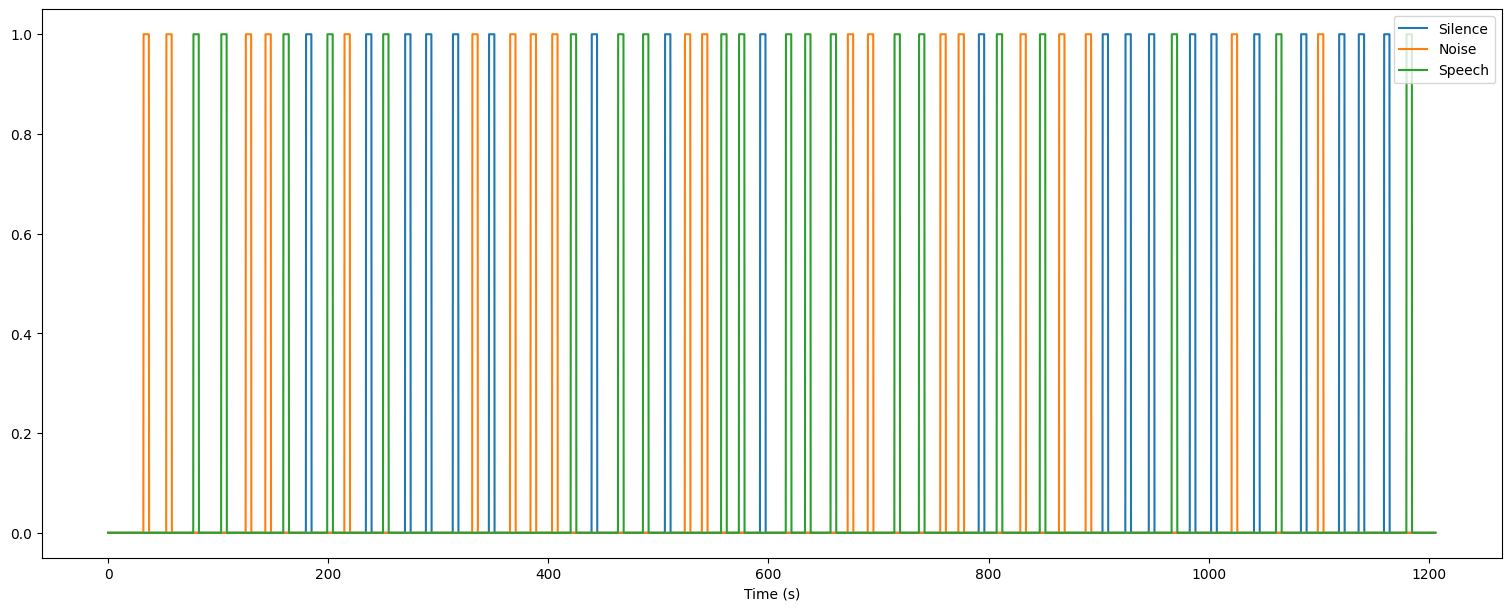

In [4]:
file = snirf_files[5]
raw_intensity = mne.io.read_raw_snirf(file)
renaming_dict = dict(zip(["1.0", "2.0", "3.0"], events_names))
raw_intensity.annotations.rename(renaming_dict)  
raw_intensity.annotations.delete(raw_intensity.annotations.description == '15.0')
raw_intensity.annotations.set_durations(5)
events, event_dict = mne.events_from_annotations(raw_intensity, verbose=False)

s = experimental_design.create_boxcar(raw_intensity, stim_dur = stim_dur)
fig, ax = plt.subplots(figsize=(15, 6), constrained_layout=True)
ax.plot(raw_intensity.times, s)
ax.legend(events_names, loc="upper right")
ax.set_xlabel("Time (s)");

## Participant-level preprocessing

I made a function called `preprocess_participant()` (defined in the `src/Main.py` script), which takes the path to a SNIRF file as argument, and does all the preprocessing for a that file. I will break this function down below. I'll use this function later to do group-level analyses.

### 1. Import raw intensity data

We will work with the first file: `sub-01_ses-01_task-AudioSpeechNoise_nirs.snirf`. Using the `mne.io.read_raw_snirf()` function, we import the data, which consists on 66 time series, each of 10,443 length. Each element in each time series is a NIRS sample for a particular chanel (or source-detector pair), and a particular wave length (760 or 850nm). We can access channel names using `.ch_names`. By default this returns an object of class `mne.Raw`, shich when printed in the console provides some high-level information.

In [5]:
file = snirf_files[1]
raw_intensity = mne.io.read_raw_snirf(file, optode_frame="head")

# for convenience, I reorder channels so that time series
# from the same channel (760 and 850nm) are together 
raw_intensity.reorder_channels(np.sort(raw_intensity.ch_names))

raw_intensity

Loading C:\Users\Gonzalo\mne_data\fNIRS-block-speech-noise\sub-02\ses-01\nirs\sub-02_ses-01_task-AudioSpeechNoise_nirs.snirf


Measurement date,"November 08, 2019 10:13:01 GMT"
Experimenter,Unknown
Participant,P02
Digitized points,36 points
Good channels,66 fNIRS (CW amplitude)
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,5.21 Hz
Highpass,0.00 Hz
Lowpass,2.60 Hz


We can define some regions of interest (ROIs) by looking at the topographic distribution of the channels, and grouping channels together based on their spacial proximity to cortical areas of interest:

In [6]:
occipital = ["S8_D6", "S8_D8", "S7_D6", "S8_D7", "S10_D8", "S7_D17", "S7_D7", "S10_D7", "S10_D18", "S9_D17"]
right_stg = ["S12_D12", "S12_D20", "S11_D12", "S11_D19", "S11_D10", "S11_D9"]
left_stg = ["S1_D13", "S1_D1", "S3_D14", "S3_D1", "S2_D1", "S4_D1", "S4_D2", "S5_D15", "S5_D2", "S6_D2", "S5_D3", "S6_D16", "S6_D3", "S6_D5"]

In [7]:
builtin_montages = mne.channels.get_builtin_montages(descriptions=True)
for montage_name, montage_description in builtin_montages:
    print(f"{montage_name}: {montage_description}")

standard_1005: Electrodes are named and positioned according to the international 10-05 system (343+3 locations)
standard_1020: Electrodes are named and positioned according to the international 10-20 system (94+3 locations)
standard_alphabetic: Electrodes are named with LETTER-NUMBER combinations (A1, B2, F4, …) (65+3 locations)
standard_postfixed: Electrodes are named according to the international 10-20 system using postfixes for intermediate positions (100+3 locations)
standard_prefixed: Electrodes are named according to the international 10-20 system using prefixes for intermediate positions (74+3 locations)
standard_primed: Electrodes are named according to the international 10-20 system using prime marks (' and '') for intermediate positions (100+3 locations)
biosemi16: BioSemi cap with 16 electrodes (16+3 locations)
biosemi32: BioSemi cap with 32 electrodes (32+3 locations)
biosemi64: BioSemi cap with 64 electrodes (64+3 locations)
biosemi128: BioSemi cap with 128 electrodes (1

In [8]:
subjects_dir = os.path.join(mne.datasets.sample.data_path(), "subjects/") 
if not os.path.exists(subjects_dir):
    os.makedirs(subjects_dir)
mne.datasets.fetch_hcp_mmp_parcellation(subjects_dir=subjects_dir, accept=True)

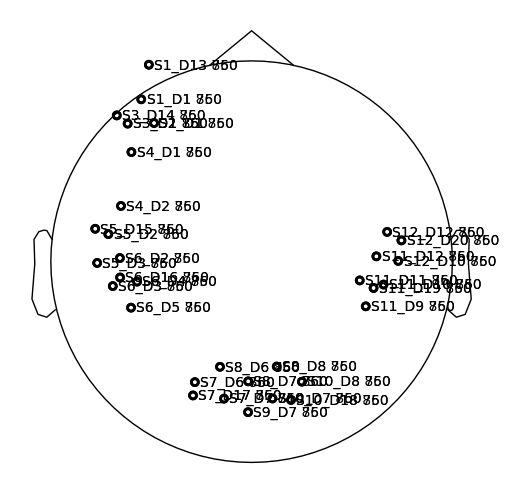

In [9]:
plt.rcParams["figure.figsize"] = (5, 5)
raw_intensity.plot_sensors(
    kind = "topomap",
    title = "Sensor positions",
    sphere = None,
    ch_groups = [occipital, right_stg, left_stg],
    show_names = True);

We can also access the data and make it a `pd.DataFrame` using `.get_data()`:

In [10]:
df = pd.DataFrame(raw_intensity.get_data())
df.insert(0, "channel", raw_intensity.ch_names)
df

,channel,0,1,2,3,4,5,6,7,8,...,6993,6994,6995,6996,6997,6998,6999,7000,7001,7002
0,S10_D18 760,0.373117,0.406615,0.421123,0.405893,0.398865,0.396260,0.427463,0.425153,0.431284,...,0.017771,0.017813,0.017639,0.017566,0.017534,0.017553,0.017308,0.017136,0.017190,0.017176
1,S10_D18 850,0.780473,0.783801,0.772075,0.780422,0.781291,0.773520,0.776232,0.797138,0.785307,...,0.007799,0.007840,0.007766,0.007583,0.007481,0.007721,0.007752,0.007623,0.007599,0.007563
2,S10_D7 760,0.021646,0.020095,0.017472,0.020800,0.034528,0.024883,0.011489,0.007011,0.002345,...,0.030684,0.030590,0.030592,0.030631,0.030532,0.030592,0.030569,0.030467,0.030478,0.030520
3,S10_D7 850,0.041469,0.035784,0.019191,0.039094,0.071108,0.023991,0.022116,0.023401,0.013003,...,0.004160,0.004150,0.004161,0.004057,0.004071,0.004064,0.004095,0.004107,0.003948,0.004139
4,S10_D8 760,0.020424,0.003523,0.015719,0.025617,0.011921,0.006031,0.024528,0.006301,0.010587,...,0.012454,0.012698,0.012977,0.012507,0.012571,0.012566,0.012513,0.012646,0.012660,0.012673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,S8_D7 850,1.108962,1.104431,1.120593,1.111486,1.106088,1.103224,1.114382,1.100727,1.093439,...,0.000506,0.000501,0.000529,0.000520,0.000532,0.000526,0.000515,0.000529,0.000540,0.000517
62,S8_D8 760,0.114517,0.115138,0.116377,0.115070,0.115761,0.115050,0.115951,0.114854,0.114427,...,0.000110,0.000107,0.000109,0.000113,0.000110,0.000107,0.000119,0.000135,0.000125,0.000100
63,S8_D8 850,0.239430,0.239603,0.240767,0.240694,0.239538,0.239285,0.240616,0.238167,0.236485,...,0.000041,0.000044,0.000037,0.000040,0.000027,0.000053,0.000021,0.000041,0.000041,0.000036
64,S9_D7 760,0.683452,0.686658,0.700583,0.690431,0.687313,0.688427,0.690382,0.682910,0.679240,...,0.002497,0.002506,0.002492,0.002528,0.002514,0.002517,0.002501,0.002511,0.002510,0.002515


The MNE-NIRS offers some convenient visualisation functions. Let's plot the first 600 seconds (10 minutes)of the time series of a particular channel (S10_D18) at the two wave lengths.

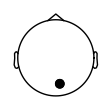

In [11]:
ch_subset = ["S10_D7 760", "S10_D7 850"]
%matplotlib inline
plt.rcParams["figure.figsize"] = (1, 1)
raw_intensity.copy().pick(ch_subset).plot_sensors();

Using matplotlib as 2D backend.


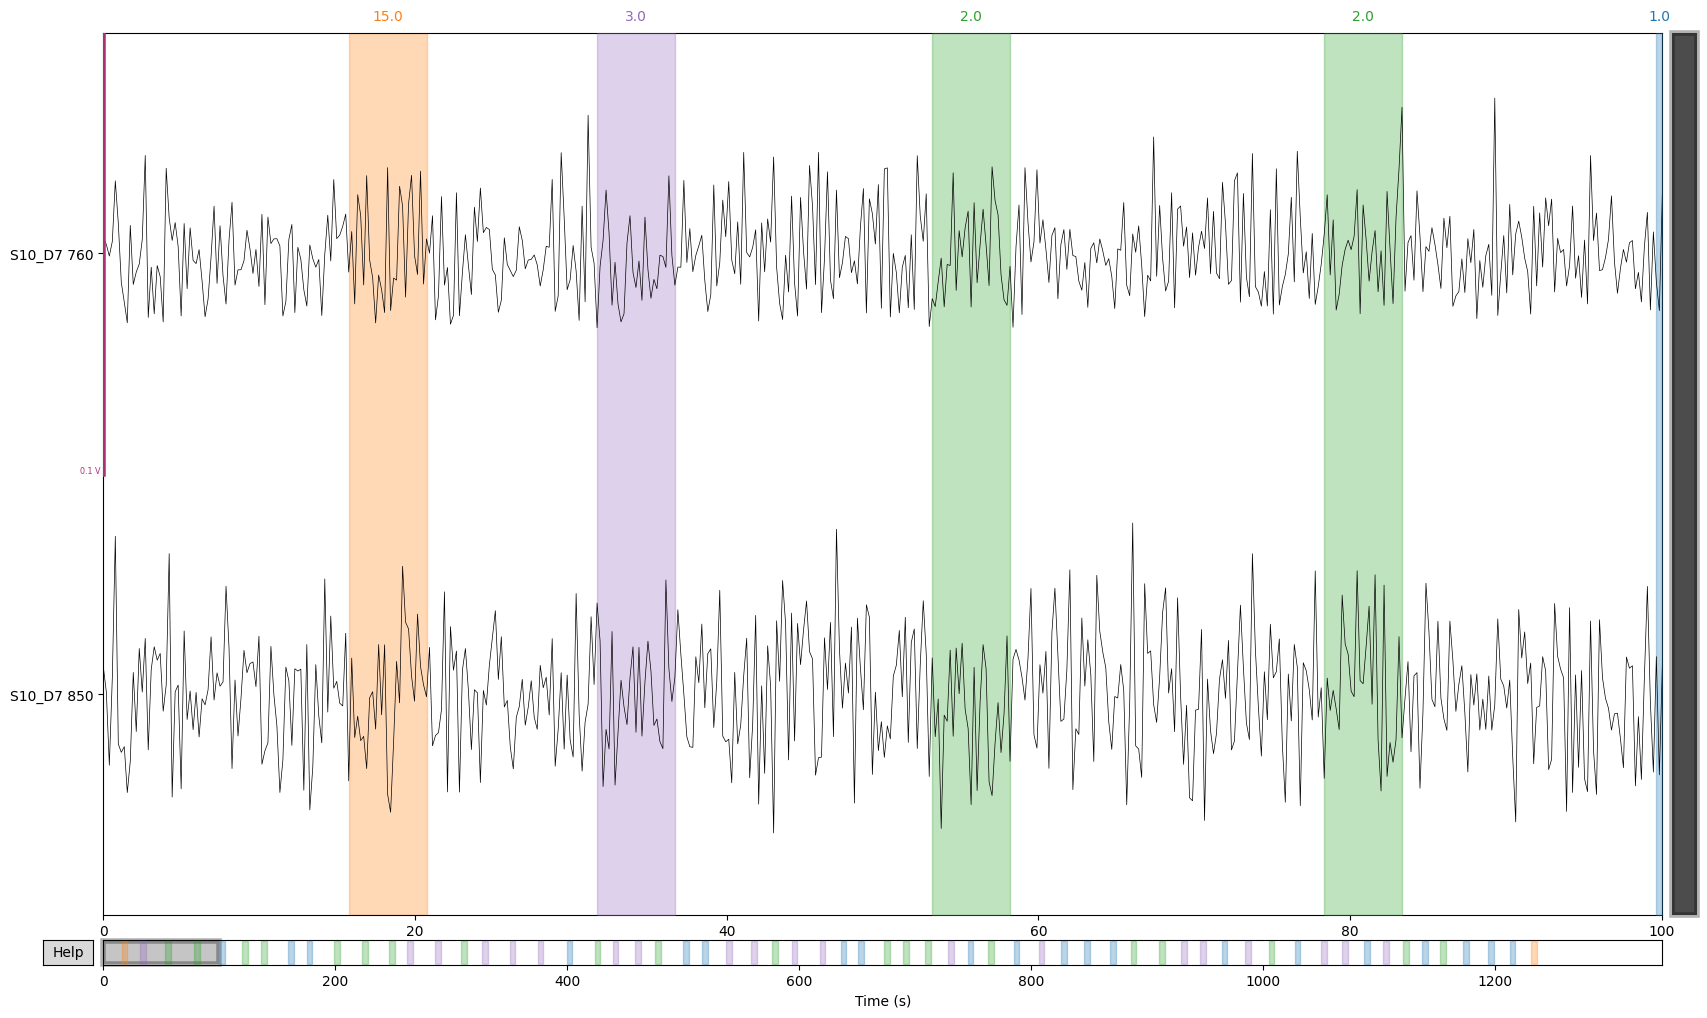

In [12]:
%matplotlib inline
raw_intensity.copy().pick(ch_subset).plot(duration = 100, clipping = None, scalings = 0.05);

### 2. Optical densities

Now we transform raw intensities into optical densities. We will do most of the pre-processing on optical densities. The resulting object gives us a very similar information as the raw intensities.

In [13]:
raw_od = mne.preprocessing.nirs.optical_density(raw_intensity)
raw_od.describe()

Reading 0 ... 7002  =      0.000 ...  1344.384 secs...
<RawSNIRF | sub-02_ses-01_task-AudioSpeechNoise_nirs.snirf, 66 x 7003 (1344.4 s), ~3.6 MB, data loaded>
ch  name         type      unit        min         Q1     median         Q3        max
 0  S10_D18 760  FNIRS_OD  V         -1.98      -0.01       0.02       0.05       3.75
 1  S10_D18 850  FNIRS_OD  V         -0.85      -0.02      -0.01       0.01       5.46
 2  S10_D7 760   FNIRS_OD  V         -4.97      -0.26       0.11       0.55       3.62
 3  S10_D7 850   FNIRS_OD  V         -3.39      -0.20       0.01       0.28       3.45
 4  S10_D8 760   FNIRS_OD  V         -5.14      -0.23       0.12       0.54       4.20
 5  S10_D8 850   FNIRS_OD  V         -4.12      -0.27       0.07       0.54       3.79
 6  S11_D10 760  FNIRS_OD  V         -0.50      -0.05      -0.02       0.04       8.33
 7  S11_D10 850  FNIRS_OD  V         -0.46      -0.05      -0.02       0.03       9.29
 8  S11_D11 760  FNIRS_OD  V         -1.10      -0.04     

In [14]:
df = pd.DataFrame(raw_od.get_data())
df.insert(0, "channel", raw_od.ch_names)
df

,channel,0,1,2,3,4,5,6,7,8,...,6993,6994,6995,6996,6997,6998,6999,7000,7001,7002
0,S10_D18 760,0.095157,0.009182,-0.025875,0.010961,0.028428,0.034980,-0.040818,-0.035399,-0.049716,...,3.139454,3.137110,3.146909,3.151056,3.152925,3.151836,3.165887,3.175898,3.172716,3.173514
1,S10_D18 850,-0.017203,-0.021458,-0.006386,-0.017138,-0.018251,-0.008255,-0.011755,-0.038332,-0.023379,...,4.588662,4.583509,4.592993,4.616735,4.630290,4.598766,4.594720,4.611579,4.614653,4.619362
2,S10_D7 760,-0.117873,-0.043524,0.096340,-0.077977,-0.584808,-0.257220,0.515532,1.009477,2.104714,...,-0.466778,-0.463706,-0.463785,-0.465049,-0.461812,-0.463795,-0.463016,-0.459671,-0.460061,-0.461419
3,S10_D7 850,-0.077511,0.069941,0.693005,-0.018533,-0.616762,0.469735,0.551129,0.494669,1.082251,...,2.221916,2.224419,2.221796,2.246987,2.243616,2.245165,2.237664,2.234835,2.274222,2.227049
4,S10_D8 760,-0.206594,1.550785,0.055256,-0.433118,0.331850,1.013297,-0.389697,0.969339,0.450547,...,0.288101,0.268658,0.246956,0.283814,0.278710,0.279116,0.283374,0.272754,0.271687,0.270637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,S8_D7 850,0.070704,0.074798,0.060270,0.068430,0.073299,0.075891,0.065828,0.078157,0.084801,...,7.762904,7.773232,7.719028,7.735810,7.712431,7.723767,7.745472,7.718839,7.698996,7.742176
62,S8_D8 760,0.058823,0.053419,0.042713,0.054004,0.048017,0.054178,0.046377,0.055890,0.059612,...,7.009554,7.038220,7.017792,6.980801,7.003194,7.037283,6.929021,6.802029,6.876593,7.105138
63,S8_D8 850,0.063951,0.063225,0.058382,0.058684,0.063500,0.064554,0.059008,0.069238,0.076325,...,8.748664,8.674908,8.844468,8.763589,9.165302,8.472155,9.386575,8.729103,8.726685,8.869228
64,S9_D7 760,0.032677,0.027998,0.007921,0.022517,0.027044,0.025425,0.022589,0.033471,0.038859,...,5.644623,5.641305,5.646588,5.632524,5.638038,5.636686,5.643103,5.638953,5.639551,5.637561


### 3. Signal quality and channel pruning.

We will first assess the quality of the signal. There are seveal ways to do them. One is the **scalp coupling index (SCI)**, which provides a measure of how well the source and detector for a given channel were attached to the scalp throughout the recording session, or at particular time points during the session. The `scale_coupling_index()` method does this, and takes two additionnal important arguments, which determine the minimum and maximum frequencies to be considered to comppute the SCI. These values should correspond to the expected heartbeat rate of the participant. This values is usually extracted from the relevant literature. In the paper:

> The scalp-coupling index was calculated for each channel between 0.7 and 1.45 Hz (corresponding to heart rates between 42 and 87 beats per second

We will set a threshold value of 0.8 for the SCI. Channels with less than 0.8 SCI will be annotated as "bad" channels, and removed from further preprocessing steps. I'm showing the SCI values as a histogram, to see how many channels fail to meet the threshold.

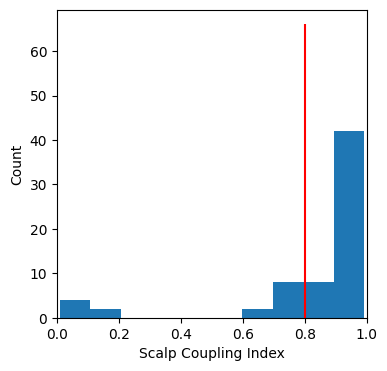

In [15]:
sci = mne.preprocessing.nirs.scalp_coupling_index(raw_od, 0.7, 1.45)
threshold_sci = 0.8

%matplotlib inline
plt.rcParams["figure.figsize"] = (4, 4)
fig, ax = plt.subplots()
ax.hist(sci)
plt.vlines(threshold_sci, ymin = 0, ymax = len(sci), color = "r")
ax.set(xlabel='Scalp Coupling Index', ylabel='Count', xlim=[0, 1]);

Most channels for this particular participant show good SCI but four. We can examine which channels fail to meet the threshold, and annotate them as "bad" channels for exclusion (see *Bad channels* section in the output). Note that since each channel has two time series (of for 760nm and one for 850nm), an excluded channel results in two time series being excluded, 8 in our case as 4 channels are annotated as "bad".

In [16]:
bad_channels = [raw_od.ch_names[i] for i in range(len(raw_od.ch_names)) if sci[i] < threshold_sci]
raw_od.info['bads'] = bad_channels
raw_od.info

Measurement date,"November 08, 2019 10:13:01 GMT"
Experimenter,Unknown
Participant,P02
Digitized points,36 points
Good channels,50 fNIRS (OD)
Bad channels,"S10_D18 760, S10_D18 850, S10_D7 760, S10_D7 850, S10_D8 760, S10_D8 850, S11_D12 760, S11_D12 850, S11_D19 760, S11_D19 850, S1_D1 760, S1_D1 850, S4_D1 760, S4_D1 850, S7_D6 760, S7_D6 850"
EOG channels,Not available
ECG channels,Not available
Sampling frequency,5.21 Hz
Highpass,0.00 Hz
Lowpass,2.60 Hz


Alternatively, we could also calculate the SCI on a time window basis, to exclude only below-threshold time windows instead of whole channels. Let's visualise the result using 12 seconds long windows. The plot on the left ("All Scores") shows the SCI index of all channels across 12 seconds long time windows. For convenience, the plot on the right ("Scores < Limit") shows the below-threshold time windows. In both plots, "bad" time series are stroke with a black line. In our case, 8 time series are annotated as "bad", corresponding to 4 "bad" channels.

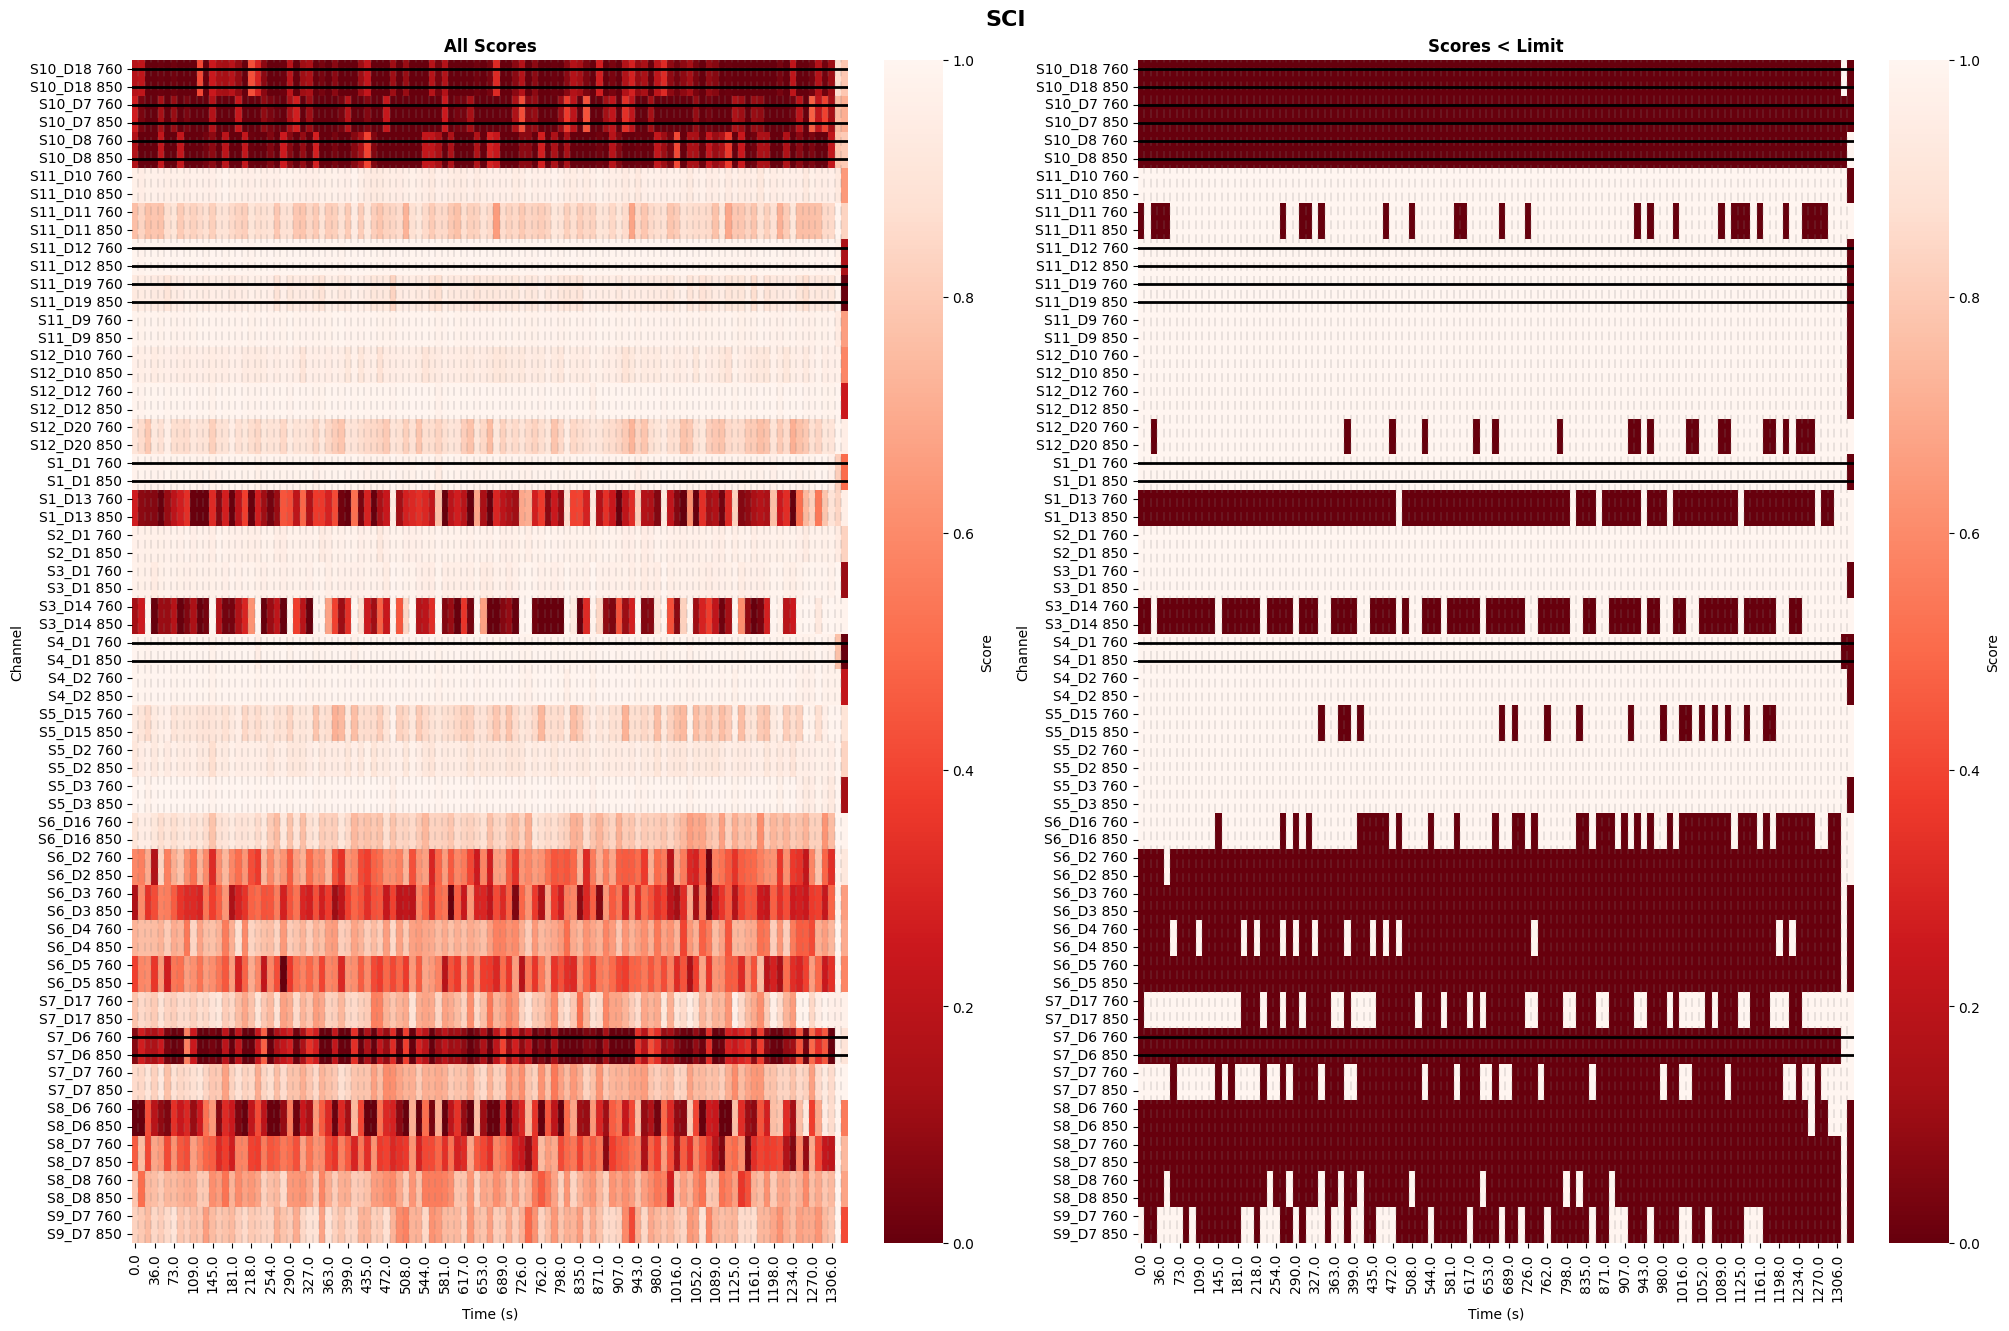

In [17]:
_, scores, times = preprocessing.scalp_coupling_index_windowed(raw_od, time_window=12)
visualisation.plot_timechannel_quality_metric(raw_od, scores, times, threshold=threshold_sci, title="SCI");

Another measure of signal quality is the **Peak Power (PP)**. Using PP as signal quality metric results in the same channels being rejected as before, for this particular participant.

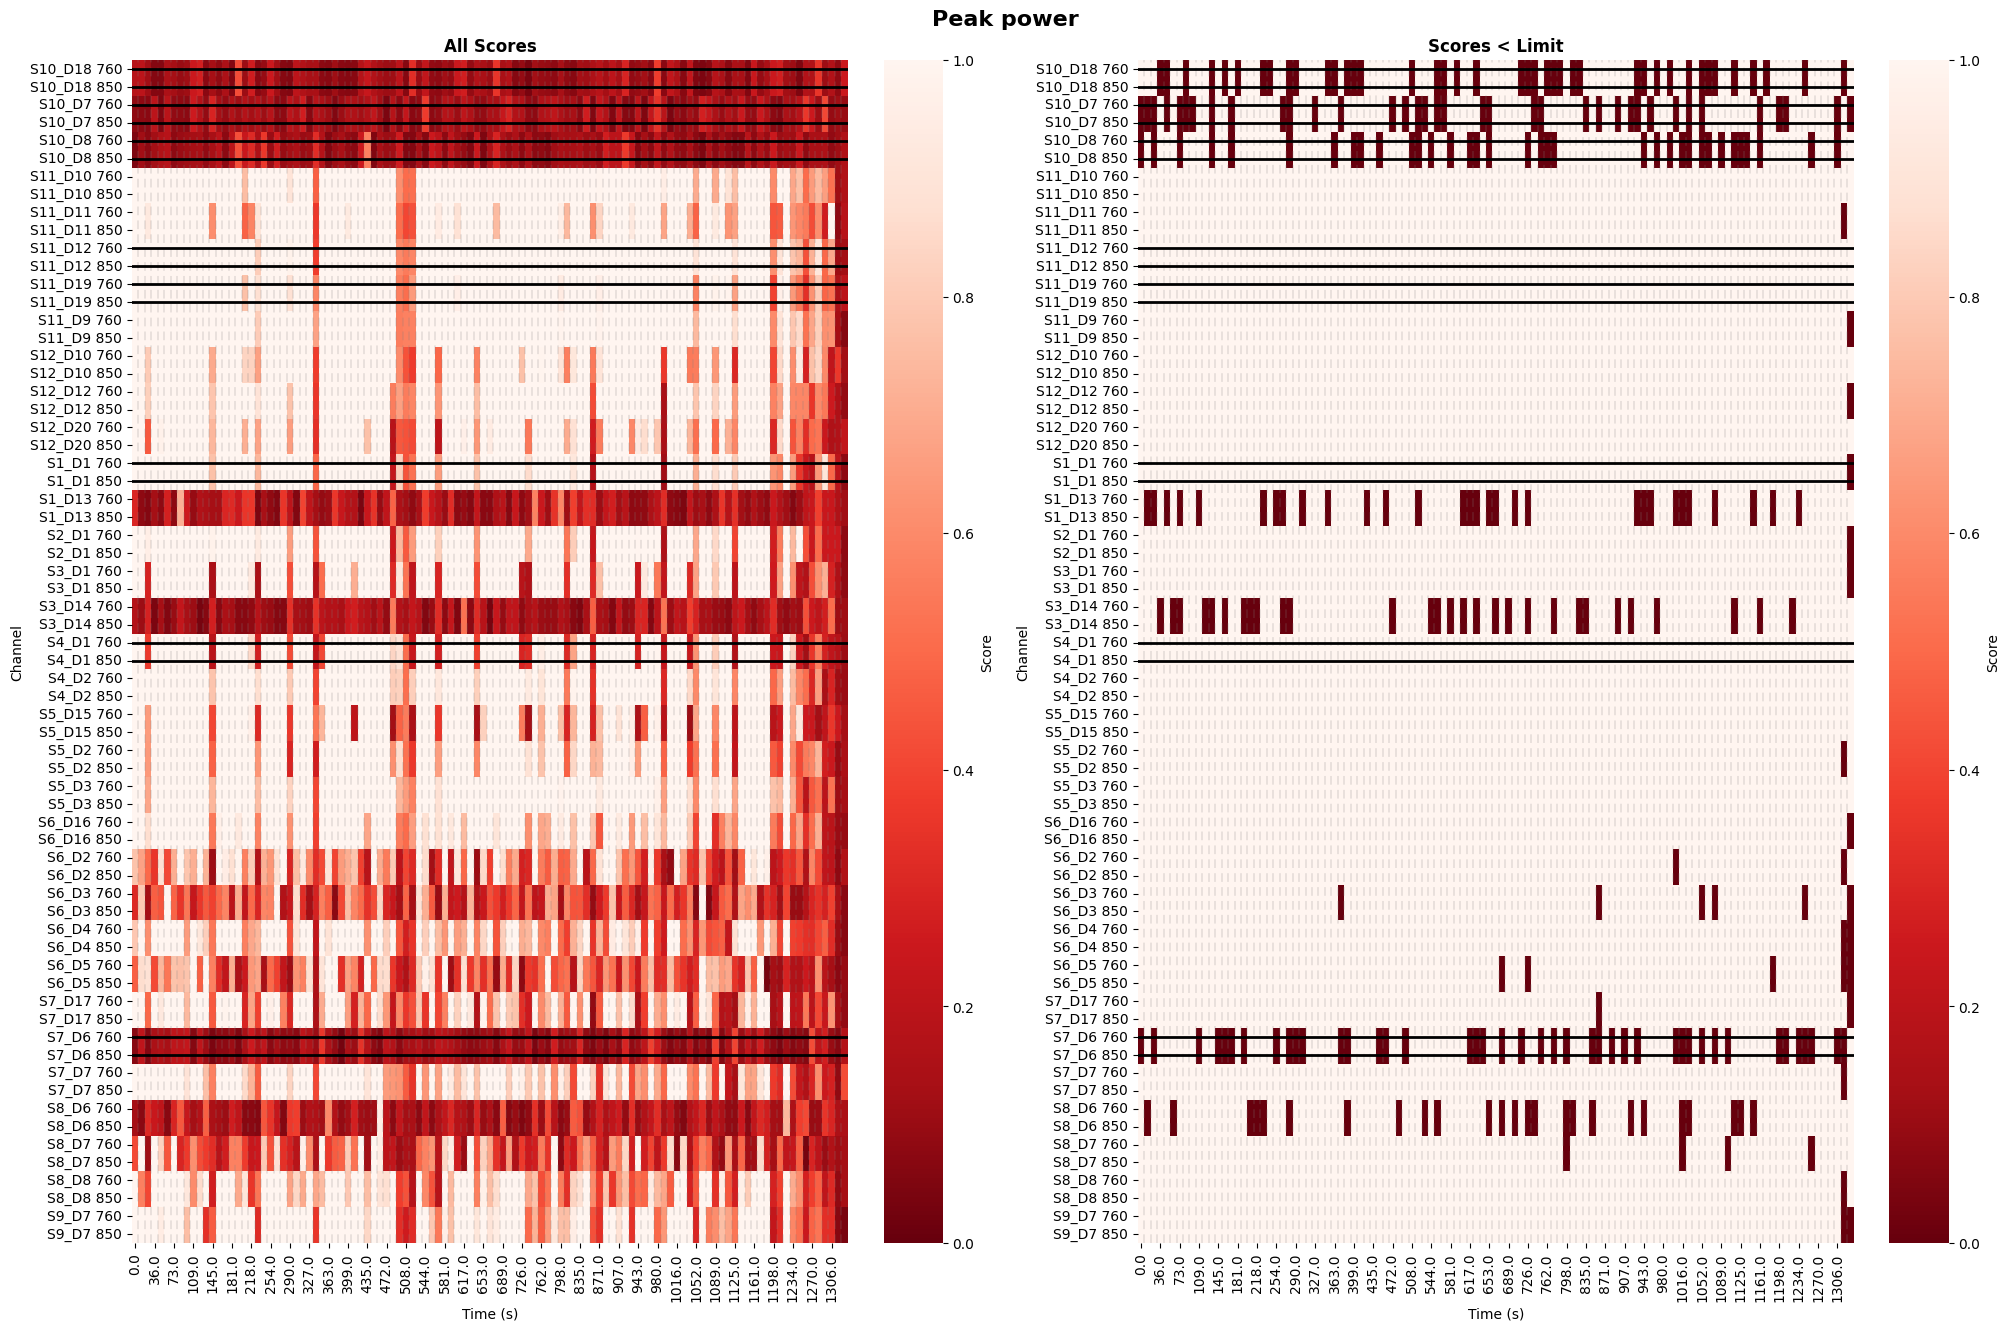

In [18]:
threshold_pp = 0.1
_, scores, times = preprocessing.peak_power(raw_od, time_window=12, threshold=threshold_pp)
visualisation.plot_timechannel_quality_metric(raw_od, scores, times, threshold=threshold_pp, title="Peak power");

### 4. Motion arctifacts

The `temporal_derivative_distribution_repair` function applies temporal derivative distribution repair to data (TDDR). This approach removes baseline shift and spike artifacts without the need for any user-supplied parameters. For illustration, see how TDDR changes the optical density in the SD11_D10 channel (760 and 850nm).

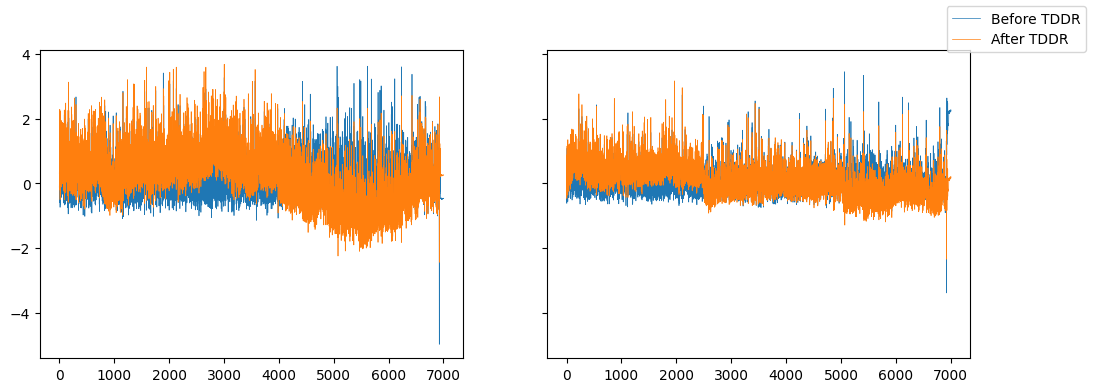

In [19]:
td_od = mne.preprocessing.nirs.temporal_derivative_distribution_repair(raw_od, verbose = True)

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 4)

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True);
before1 = np.transpose(raw_od.copy().pick(ch_subset[0]).get_data())
after1 = np.transpose(td_od.copy().pick(ch_subset[0]).get_data())
l1, l2 = ax1.plot(np.hstack([before1, after1]), linewidth=1/2)

before2 = np.transpose(raw_od.copy().pick(ch_subset[1]).get_data())
after2 = np.transpose(td_od.copy().pick(ch_subset[1]).get_data())
ax2.plot(np.hstack([before2, after2]), linewidth=1/2)

fig.legend((l1, l2), ("Before TDDR", "After TDDR"))

## 5. Short-channel regression

In [20]:
enhanced_od = signal_enhancement.short_channel_regression(td_od)

## 6. Convert to HbO and HbR concentration changes

We now use the modified Beer-Lambert law (mBLL) to transform optical densities to a haemodynamic response (HDR), that is relative changes in concentration of HbO and HbR. We will use a partial pathlength factor (PPF) of 0.1, as in the paper.

In [21]:
ppf = 0.1
raw_haemo = mne.preprocessing.nirs.beer_lambert_law(td_od, ppf=ppf)
raw_haemo = channels.get_long_channels(raw_haemo) 
raw_haemo

Measurement date,"November 08, 2019 10:13:01 GMT"
Experimenter,Unknown
Participant,P02
Digitized points,36 points
Good channels,"19 Oxyhemoglobin, 19 Deoxyhemoglobin"
Bad channels,"S10_D7 hbo, S10_D7 hbr, S10_D8 hbo, S10_D8 hbr, S11_D12 hbo, S11_D12 hbr, S1_D1 hbo, S1_D1 hbr, S4_D1 hbo, S4_D1 hbr, S7_D6 hbo, S7_D6 hbr"
EOG channels,Not available
ECG channels,Not available
Sampling frequency,5.21 Hz
Highpass,0.00 Hz
Lowpass,2.60 Hz


Let's visualise the HDR for our channel during the first 10 minutes of task:

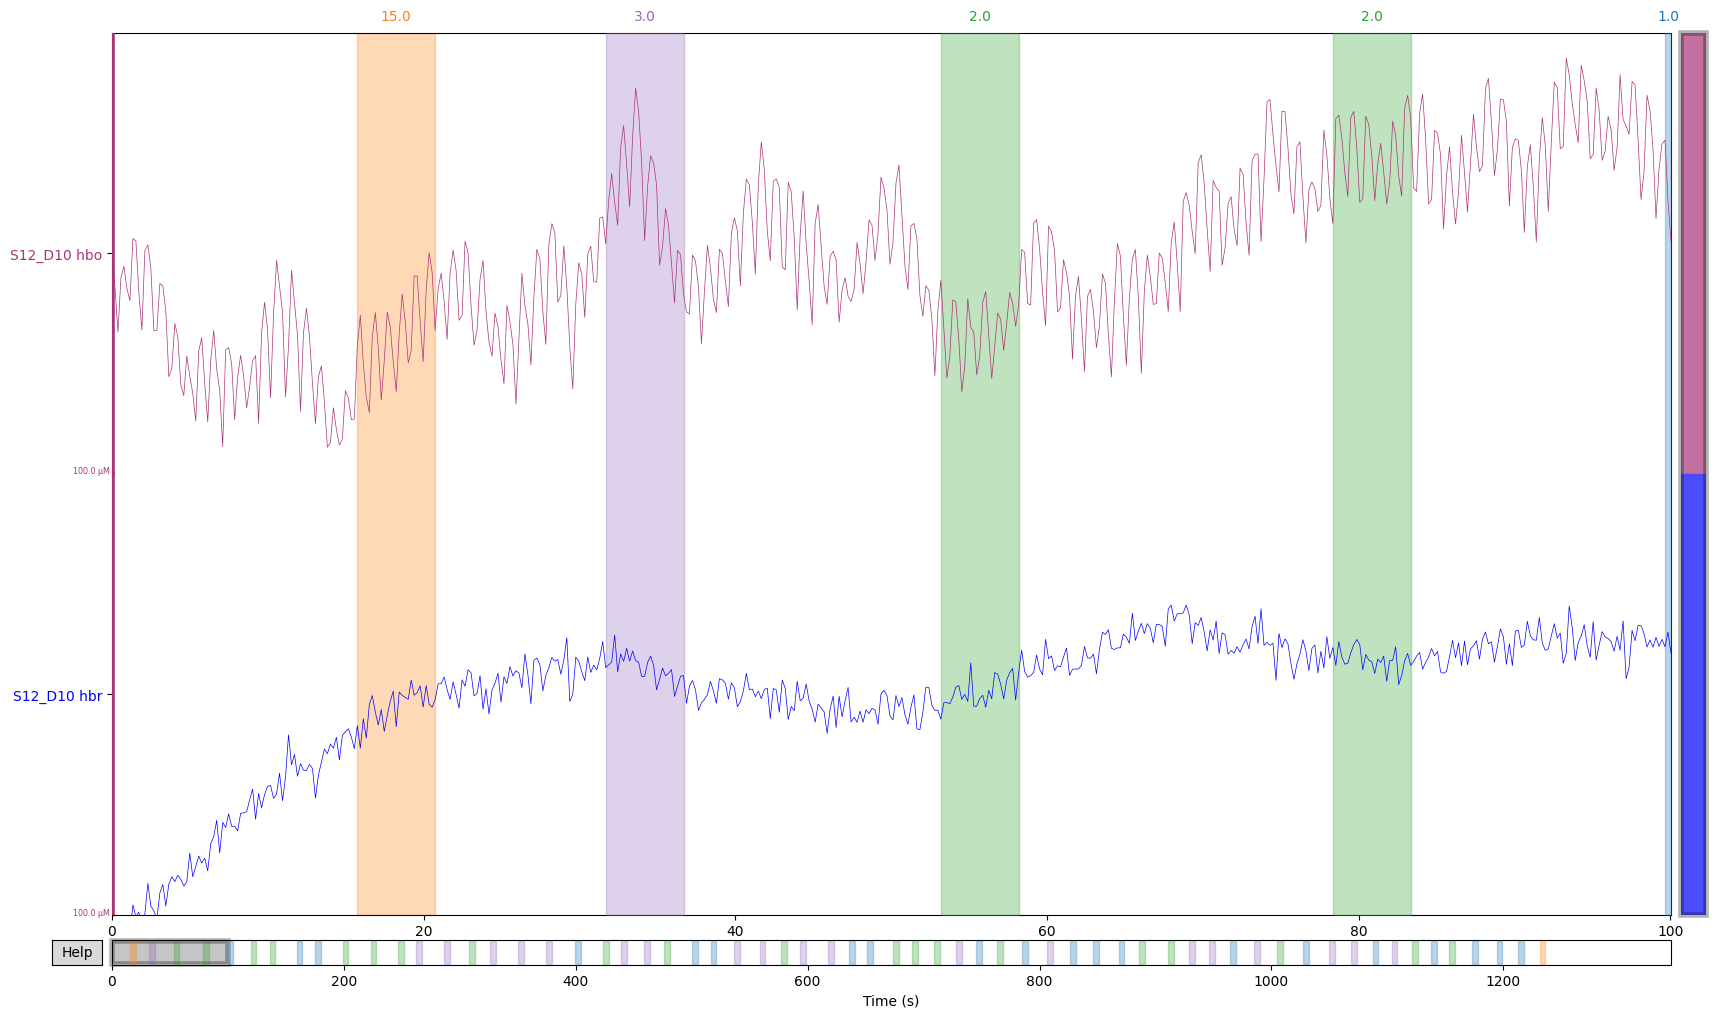

In [22]:
%matplotlib inline
ch_subset = ["S12_D10 hbo", "S12_D10 hbr"]
raw_haemo.copy().pick(ch_subset).plot(duration = 100, clipping = None, scalings = 5e-5);

## 7. Negative correlation

In [23]:
anti_haemo = signal_enhancement.enhance_negative_correlation(raw_haemo)

## 8. Physiological arctifacts

The signal is a function of the contribution of many sources, many of which are of no interest (e.g., do not correspond to the haemodynamic response evoke by our events). Although the contribution of some of those events is negligible, we must acount for others that might influence the signal more strongly, and event be correlated with the presentation rate of our events. These sources can broadly be classified as **physiological arctifacts** or **motion arctifacts**. I'll focus on physiological arctifacts for now.

The relevant physiological arctifacts are rhytmic, and oscillate are certain frequencies. The frequency range of some physiological arctifacts is higher or lower than that of the haemodynamic signal of interest. This is the case, for instance, of the heartbeat rate. These components can be filtered out using some kind of frequency filter. One of such filtered is the **band pass** filter, which decomposes the signal into different frequency bands, computes the relative contribution (power) of each, and removes the frequency bands that fall outside of the freuqency range of interest. The `.filter` method from the mne package (which we can apply to any object of class Raw) can do this.

C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_27916\2746845393.py:3: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  anti_haemo.compute_psd(verbose = False).plot(average = False);


Plotting power spectral density (dB=True).


c:\Users\Gonzalo\Documents\projects\fnis-fresh\env\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 0.7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 0.70 Hz
- Upper transition bandwidth: 0.30 Hz (-6 dB cutoff frequency: 0.85 Hz)
- Filter length: 3439 samples (660.288 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_27916\2746845393.py:8: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  f_haemo.compute_psd(verbose = False).plot(average = False);


Plotting power spectral density (dB=True).


c:\Users\Gonzalo\Documents\projects\fnis-fresh\env\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


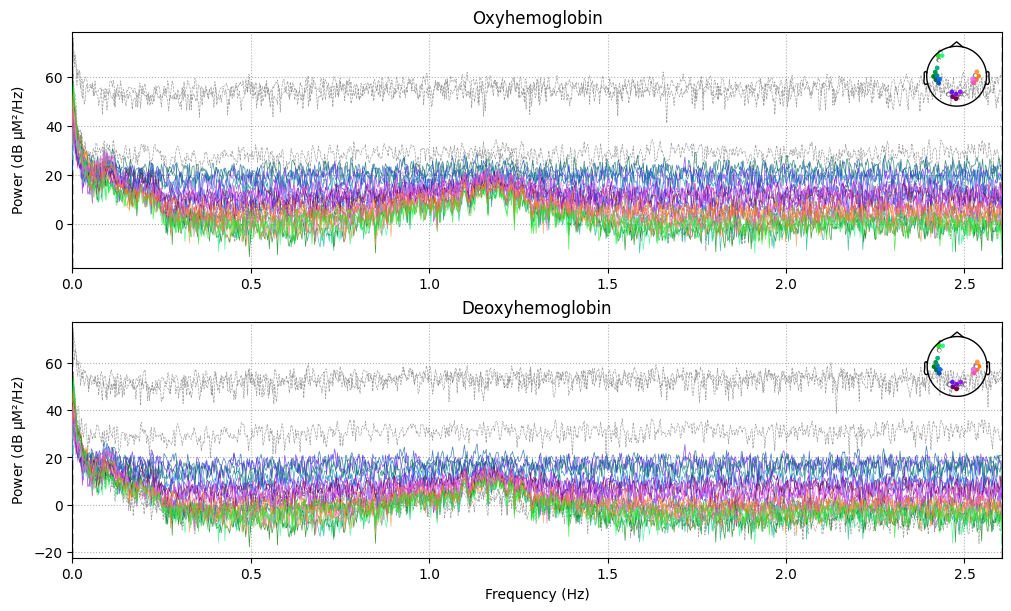

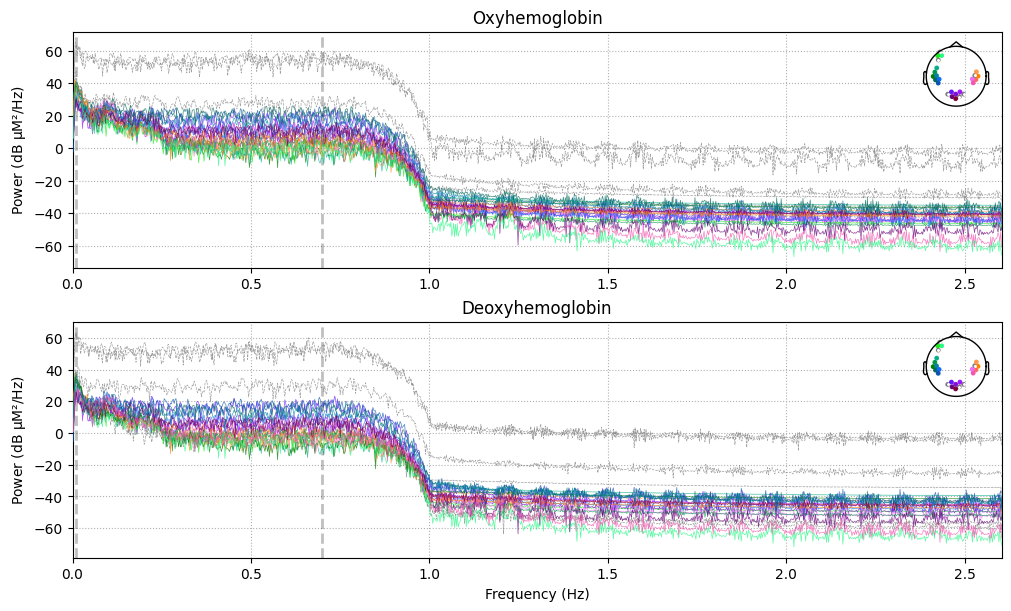

In [24]:
l_freq = 0.01
h_freq = 0.7
anti_haemo.compute_psd(verbose = False).plot(average = False);
f_haemo = anti_haemo.filter(l_freq=l_freq, 
                         h_freq=h_freq, 
                         l_trans_bandwidth = 0.005, 
                         h_trans_bandwidth=0.3)
f_haemo.compute_psd(verbose = False).plot(average = False);

### 9. Epoching

To average the signal across events (or trials), we need to chunk the time series into *epochs*. Each epoch is a time span that encompasses an event of interest (in our case, the signal inmediately before and after each trigger). The `mne.Epochs` can do this for us. We will define epochs as the time 3 seconds before each trigger (-3), and 14 seconds after (+14) the trigger, which should be enough for the haemodynamic response to rise and go back to baseline, while avoiding the overlap with next stimulus onset.

The `.Epochs()` method normalises the signal by calculating the mean of the pre-trigger signal, and subtracting it from the post-trigger signal. That way, the signal at the trigger onset stats at 0 amplitude. Epochs with peark-to-peak difference higher than 100μM are flagged as "bad". Signals are also linearly dentrended (`detrend = 1`).

In [25]:
# short-channel regression
reject_criteria = dict(hbo=100e-6)
tmin, tmax = -3, 14
epochs = mne.Epochs(f_haemo, events, event_id=event_dict,
                    tmin=tmin, tmax=tmax,
                    reject=reject_criteria,
                    proj=True, baseline=(None, 0), preload=True,
                    detrend=1, verbose=False)

We can also visualise the rejection of epochs:

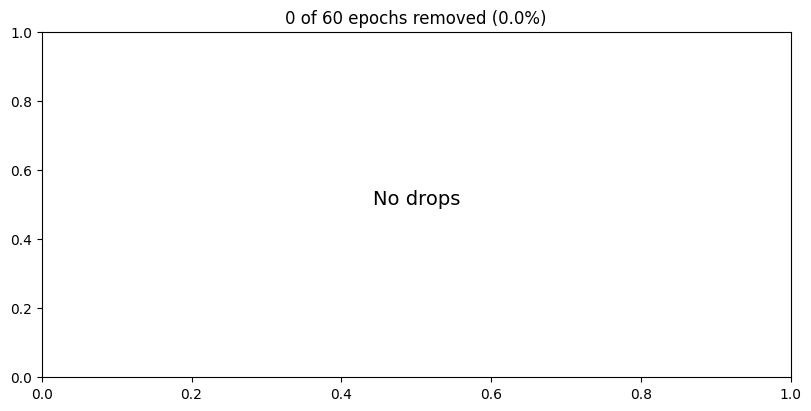

In [26]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (8, 4)
epochs.plot_drop_log();

Finally, we can also visualise the ODs averaged across epochs:

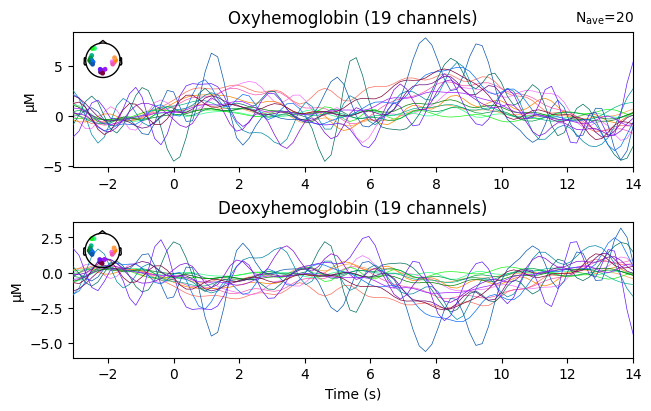

In [27]:
epochs["Silence"].average().plot();

Effective window size : 393.216 (s)


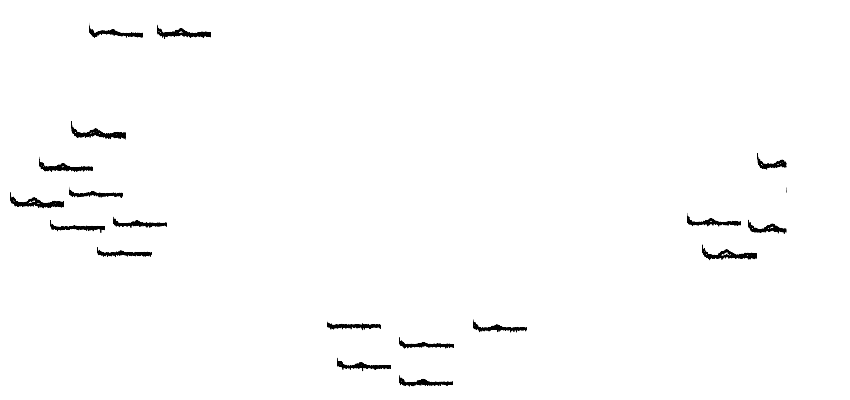

In [28]:
raw_haemo.compute_psd().plot_topo(
    fig_facecolor = "white",
    axis_facecolor = "white",
    color = "k");

## Group-level analyses

Now we can use the `preprocess_participant()` function to preprocess all datasets and do group-level analyses.

In [29]:
all_evokeds = collections.defaultdict(list)
epochs_group = pd.DataFrame()
for f in snirf_files:  # Loop from first to fifth subject
    # analyse data and return both ROI and channel results
    raw_haemo, epochs = preprocess_participant(f)
    e = epochs.to_data_frame()
    e["file"] = os.path.basename(f)
    epochs_group = pd.concat([epochs_group, e])
    # save individual-evoked participant data along with others in all_evokeds
    for cidx, condition in enumerate(epochs.event_id):
        all_evokeds[condition].append(epochs[condition].average())
        
epochs_group.to_csv(os.path.join("..", "out", "hdr.csv"), index = False)
epochs_group

,time,condition,epoch,S10_D7 hbo,S10_D7 hbr,S10_D8 hbo,S10_D8 hbr,S11_D10 hbo,S11_D10 hbr,S11_D11 hbo,...,S7_D7 hbr,S8_D6 hbo,S8_D6 hbr,S8_D7 hbo,S8_D7 hbr,S8_D8 hbo,S8_D8 hbr,S9_D7 hbo,S9_D7 hbr,file
0,-3.072,Noise,0,-11.694750,18.232256,-41.314697,48.932428,-2.553831,0.839844,-2.311599,...,0.049816,-2.745360,0.735859,-1.623696,-1.662516,0.029631,-0.007853,2.410155,-0.534787,sub-01_ses-01_task-AudioSpeechNoise_nirs.snirf
1,-2.880,Noise,0,-5.352048,15.972058,-23.752051,28.229896,-2.152186,0.707760,-0.893365,...,0.613877,2.298914,-0.616195,-0.910362,-1.166083,0.320542,-0.084950,1.413257,-0.313587,sub-01_ses-01_task-AudioSpeechNoise_nirs.snirf
2,-2.688,Noise,0,-1.041696,13.764657,-4.607126,8.685292,-1.938976,0.637644,-0.784247,...,0.802687,5.593484,-1.499262,-0.683951,1.080387,0.442327,-0.117225,0.721269,-0.160042,sub-01_ses-01_task-AudioSpeechNoise_nirs.snirf
3,-2.496,Noise,0,-1.670090,12.199087,7.500479,-0.197421,-1.849327,0.608163,-1.979072,...,0.427710,5.581711,-1.496107,-0.671145,3.676240,0.603450,-0.159926,0.844008,-0.187276,sub-01_ses-01_task-AudioSpeechNoise_nirs.snirf
4,-2.304,Noise,0,-4.711534,8.219015,11.160921,2.773801,-1.796210,0.590695,-3.448162,...,-0.285655,2.267587,-0.607798,-0.534050,4.836549,0.855451,-0.226711,1.481186,-0.328659,sub-01_ses-01_task-AudioSpeechNoise_nirs.snirf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5395,13.248,Noise,59,-1.720390,0.585882,-8.778088,2.095069,-1.453525,0.637913,-3.067868,...,-0.005338,-1.533995,0.470513,-6.943051,2.246104,-3.006143,0.983612,-4.974827,1.643355,sub-17_ses-01_task-AudioSpeechNoise_nirs.snirf
5396,13.440,Noise,59,-1.915096,0.652190,-7.837361,1.870546,-1.189764,0.522155,-2.869556,...,-0.321376,-0.767127,0.235296,-6.768635,2.189679,-2.234584,0.731158,-5.043062,1.665896,sub-17_ses-01_task-AudioSpeechNoise_nirs.snirf
5397,13.632,Noise,59,-1.591487,0.541984,-6.476856,1.545834,-0.831368,0.364865,-3.135956,...,-0.579977,0.488243,-0.149756,-6.186357,2.001310,-1.461159,0.478092,-4.595838,1.518162,sub-17_ses-01_task-AudioSpeechNoise_nirs.snirf
5398,13.824,Noise,59,-0.677221,0.230629,-5.183652,1.237184,-0.581876,0.255369,-3.775833,...,-0.688500,1.794461,-0.550405,-5.333219,1.725317,-0.888554,0.290735,-3.830142,1.265227,sub-17_ses-01_task-AudioSpeechNoise_nirs.snirf
